## 3. Podstawowe metody klasyfikacji


In [52]:
library(yaml)
library(corrplot)
library(ggplot2)
library(reshape2)
library(MASS)
library(class)

# Global options
options(repr.plot.width = 12, repr.plot.height = 12)

### 3.1 Wczytywanie konfiguracji (*config.yaml*):

In [2]:
config <- yaml.load_file("../config.yaml")

train_filepath <- file.path("..", config$paths$data_train)
test_filepath <- file.path("..", config$paths$data_test)

### 3.2 Przygotowanie danych

Omawiany dotychczas zbiór posiada numeryczną zmienną docelową - ```elo```. Można jednak w prosty sposób przystosować ten sam zbiór do pracy z algorytmami klasyfikacji, stosując podział wartości zmiennej docelowej na dwie grupy, które będą stanowiły zarazem dwie osobne klasy.

W tym przypadku celem będzie predykcja czy dany gracz posiada ranking powyżej pewnego pułapu, a punktem podziału będzie wartość **2000 elo** rankingu - powyżej tej wartości wyróżniamy klasę pozytywną (1), a poniżej - negatywną (0).

Dla celów tej analizy wczytujemy także zbiór testowy z pliku *test.csv*.

In [3]:
data_train <- read.csv(train_filepath)
data_test <- read.csv(test_filepath)

# Add new target variable and remove the old one
# - NOTE: we treat an exact rating of 2000 elo as "Above 2000" since it is more intuitive approach
data_train$elo_category <- factor(ifelse(data_train$elo >= 2000, "Above 2000", "Below 2000"))
data_train$elo_category <- factor(data_train$elo_category, levels = c("Below 2000", "Above 2000"))  # Important! Repair factor levels!
data_train$elo <- NULL

data_test$elo_category <- factor(ifelse(data_test$elo >= 2000, "Above 2000", "Below 2000"))
data_test$elo_category <- factor(data_test$elo_category, levels = c("Below 2000", "Above 2000"))  # Important! Repair factor levels!
data_test$elo <- NULL

cat("\nPrzykładowe elementy zbioru:")
head(data_train, 5)


Przykładowe elementy zbioru:

,name,games,avg_moves,frac_nonterm,avg_cp_loss,avg_inacc,avg_mist,avg_blund,frac_time_win,frac_time_loss,avg_time_good,avg_time_inaccm,avg_time_blund,avg_mat_imb_per_mv,avg_book_moves,elo_category
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,astrolfos,11,31.54545,0.5454545,64.03458,1.636364,1.363636,1.545455,0.6301667,0.9950000,11.797980,16.878788,18.647059,4.201729,1.818182,Below 2000
2,barbarik77,10,35.00000,1.0000000,81.44857,1.800000,2.600000,1.800000,0.4783333,0.3511111,5.878472,7.522727,8.833333,3.862857,2.100000,Below 2000
3,FawkingAwesome,10,29.10000,0.7000000,110.08935,2.500000,2.400000,1.900000,0.4477778,0.6200000,10.251121,15.571429,19.000000,2.127148,2.300000,Below 2000
4,ZeNNgiLy,10,28.40000,0.5000000,102.34859,2.100000,1.700000,1.800000,0.4490476,0.7088889,9.872807,16.368421,16.055556,3.566901,2.500000,Below 2000
5,lelouch_VV,10,44.50000,0.5000000,68.60674,2.600000,2.900000,2.200000,0.5946667,0.5845833,7.687500,9.945455,15.136364,5.368539,0.300000,Below 2000


Możemy od razu wyrzucić też kolumny ```name``` i ```games```, które nie są istotne dla zadania klasyfikacji.

In [4]:
data_train$name <- NULL
data_train$games <- NULL

data_test$name <- NULL
data_test$games <- NULL

### 3.3 Badanie korelacji między zmiennymi

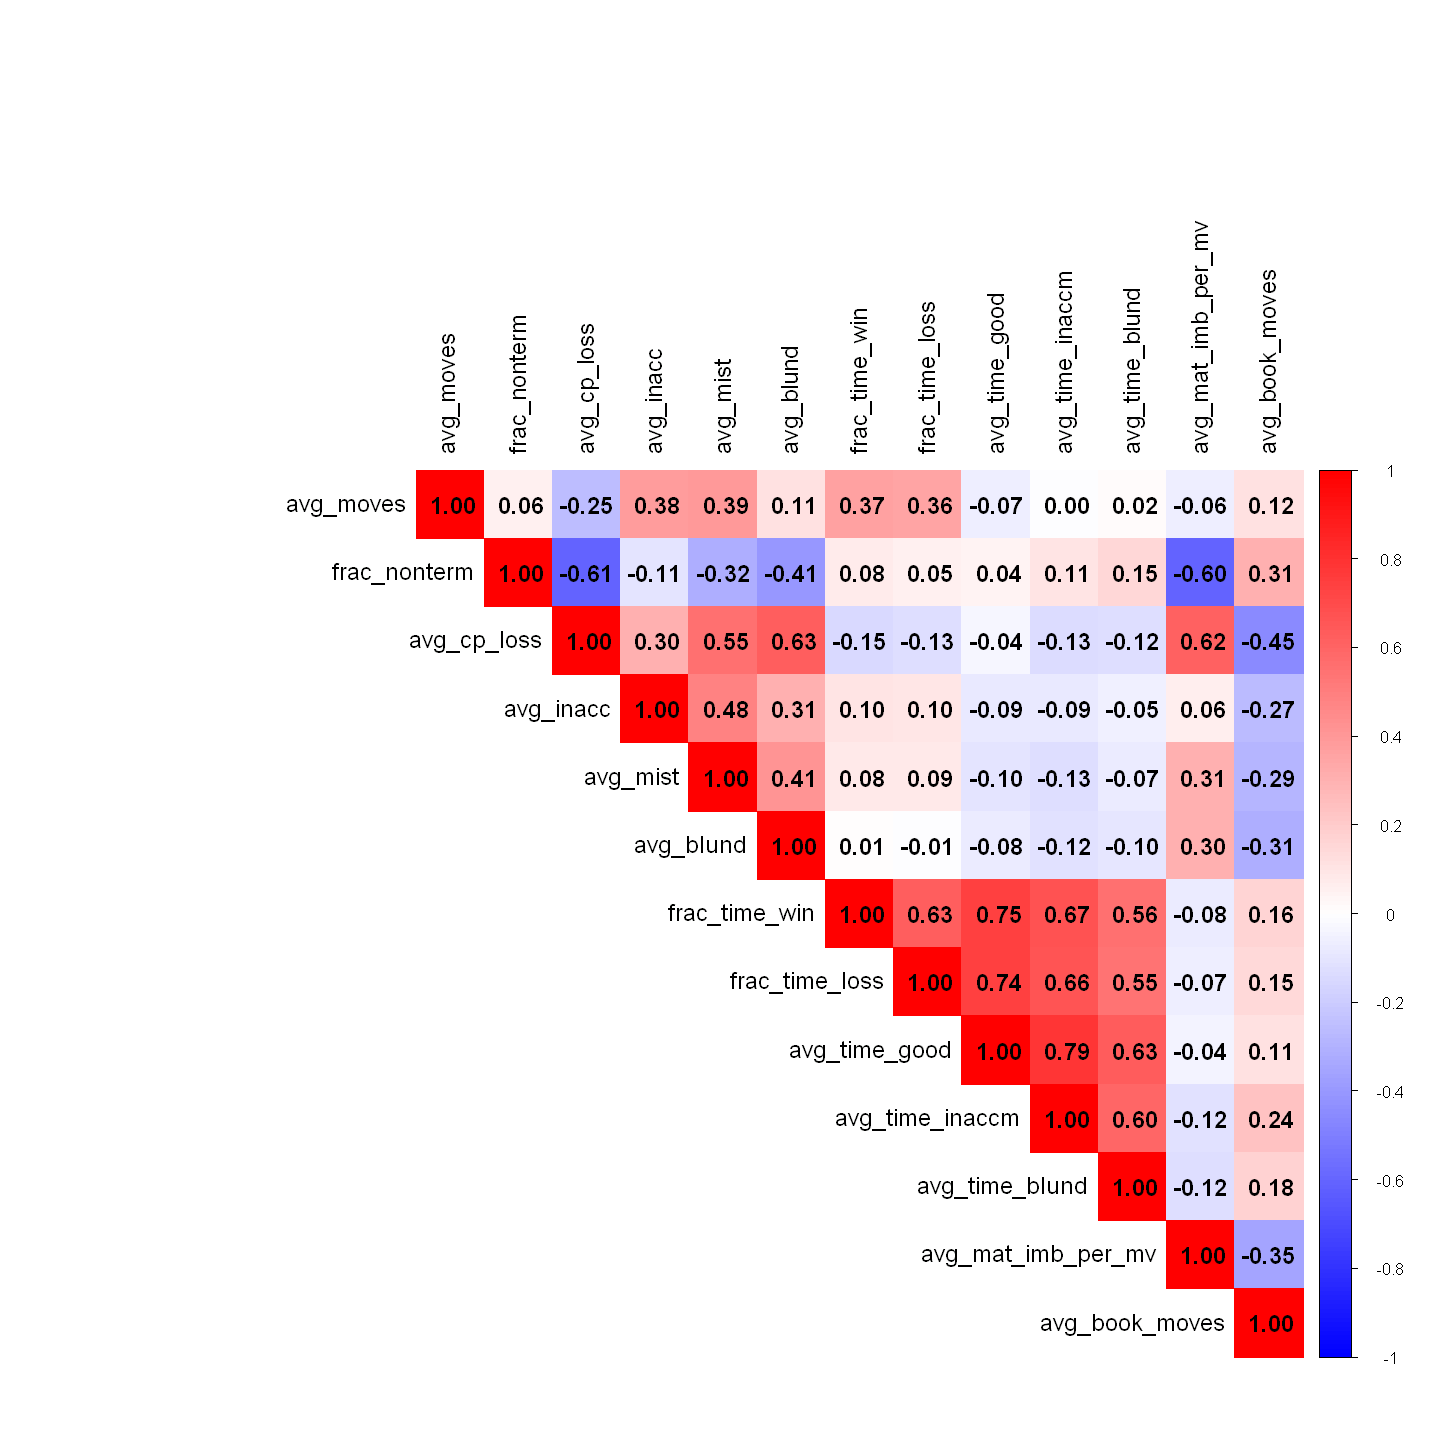

In [13]:
# - target variable: id 14
cor_matrix <- cor(data_train[-14])

corrplot(cor_matrix,
         method = "color",
         type = "upper",
         col = colorRampPalette(c("blue", "white", "red"))(200),
         tl.col = "black",   # kolor etykiet (czarny)
         tl.cex = 1.2,       # rozmiar etykiet
         addCoef.col = "black",  # kolor współczynników
         number.cex = 1.2)   # rozmiar liczb korelacji

Na podstawie powyższej wizualizacji korelacji pomiędzy zmiennymi możemy wyciągnąć kilka interesujących wniosków:
- Liczba ruchów jest ujemnie skorelowana ze średnią stratą w centypionach ($c = -0.25$). Oznacza to, że z reguły dłuższe partie są spokojniejsze i stosunek liczby błędów do wszystkich ruchów jest niższy (czym niższa średnia strata w centypionach, tym większa w uśrednieniu precyzja gry danego gracza).
- Średnia strata w centypionach, a także ilość błędów różnej skali, jest ujemnie skorelowania z liczbą ruchów książkowych ($c = -0.45$) - co potwierdza, iż znajomość teorii prowadzi do mniejszej liczby błędów, lub też po prostu do pozycji, które są przez graczy lepiej rozumiane.
- Nierównowaga materialna jest dodatnio skorelowana z poważnymi błędami ($c = 0.30$), ale nie wykazuje wyraźnej korelacji z drobnymi niedokładnościami ($c = 0.06$). Świadczy to o tym, że powstanie dużej nierównowagi materialnej zazwyczaj związane jest z pojawieniem się poważnego błędu którejś ze stron.
 - Odsetek partii kończących się rezygnacją którejś ze stron lub zgodą na remis (a nie np. matem) jest ujemnie skorelowany z ilością błędów różnej skali ($c < -0.11$), co świadczy o tym, że partie kończące się matem grane są na niższej dokładności niż partie kończące się w sposób wcześniej opisany. Może to sugerować, iż gracze słabsi mniej chętnie zgadzają się na poddanie lub zremisowanie partii.

### 3.4 Regresja logistyczna

Zaczynamy od regresji logistycznej z wykorzystaniem wszystkich istotnych cech:

In [14]:
dir_logistic <- list()
dir_logistic$fit <- glm(elo_category ~ ., 
                        family = binomial, data = data_train)

summary(dir_logistic$fit)


Call:
glm(formula = elo_category ~ ., family = binomial, data = data_train)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.823247   0.581100   1.417 0.156569    
avg_moves           0.149163   0.013090  11.396  < 2e-16 ***
frac_nonterm       -0.315722   0.306235  -1.031 0.302550    
avg_cp_loss        -0.037021   0.005182  -7.144 9.07e-13 ***
avg_inacc          -0.293872   0.083021  -3.540 0.000401 ***
avg_mist           -0.258941   0.101762  -2.545 0.010941 *  
avg_blund          -1.690007   0.112379 -15.038  < 2e-16 ***
frac_time_win      -0.087178   0.412478  -0.211 0.832612    
frac_time_loss      1.438923   0.346014   4.159 3.20e-05 ***
avg_time_good      -0.213638   0.035903  -5.950 2.68e-09 ***
avg_time_inaccm     0.013347   0.011115   1.201 0.229840    
avg_time_blund      0.031058   0.006329   4.907 9.23e-07 ***
avg_mat_imb_per_mv -0.888175   0.051501 -17.246  < 2e-16 ***
avg_book_moves      0.622754   0.047093  13.224  < 2e-

Widzimy, iż większośc zmiennych okazała się być istotna statystycznie. Szczególnie istotna jest zmienna ```avg_blund``` oznaczająca średnią ilość krytycznych błędów popełnianych przez gracza. Współczynnik $-1.690007$ oznacza, iż wzrost liczby takich błędów wyraźnie zmniejsza prawdopodobieństwo, że dany gracz ma powyżej 2000 elo rankingu.

Inną bardzo istotną zmienną jest ```avg_cp_loss```. Zmiana średniej straty w centypionach danego gracza o 10 w dół powoduje powoduje zmianę prawdopodobieństwa w modelu:
$$
\log\left(\frac{1 - p}{p}\right) = \beta_0 + \sum_{i=1}^{n} \beta_i x_i
$$
powoduje zmianę *log-odds* o $Δ=−0.037021×10=−0.37021$, co oznacza zwiększenie prawdopodobieństwa klasy pozytywnej (powyżej 2000 elo) o $e^{-0.37021} \approx 0.690$ , czyli około 69%. Precyzja i kontrola w grze danego gracza jest więc decydującym czynnikiem w predykcji, czy dysponuje on rankingiem powyżej 2000.

W następnym kroku dokonujemy predykcji za pomocą utworzonego modelu regresji logistycznej:

In [15]:
# Calculate probabilities and make predictions
dir_logistic$probs <- predict(dir_logistic$fit, type = "response")
dir_logistic$predicted <- ifelse(dir_logistic$probs > 0.5, "Above 2000", "Below 2000")

# Create confusion matrix
dir_logistic$cm <- table(dir_logistic$predicted, data_train$elo_category)

In [16]:
# A helper function for visualizing confussion matrices in elegant way
plot_confusion_heatmap <- function(cm) {
  # Convert to data.frame for ggplot2 compatibility
  cm_df <- as.data.frame(as.table(cm))
  colnames(cm_df) <- c("True", "Predicted", "Freq")
  
  ggplot(cm_df, aes(x = Predicted, y = True, fill = Freq)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Freq), size = 8) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    labs(title = "Macierz pomyłek", x = "Przewidziana klasa", y = "Rzeczywista klasa") +
    theme_minimal(base_size = 20)
}

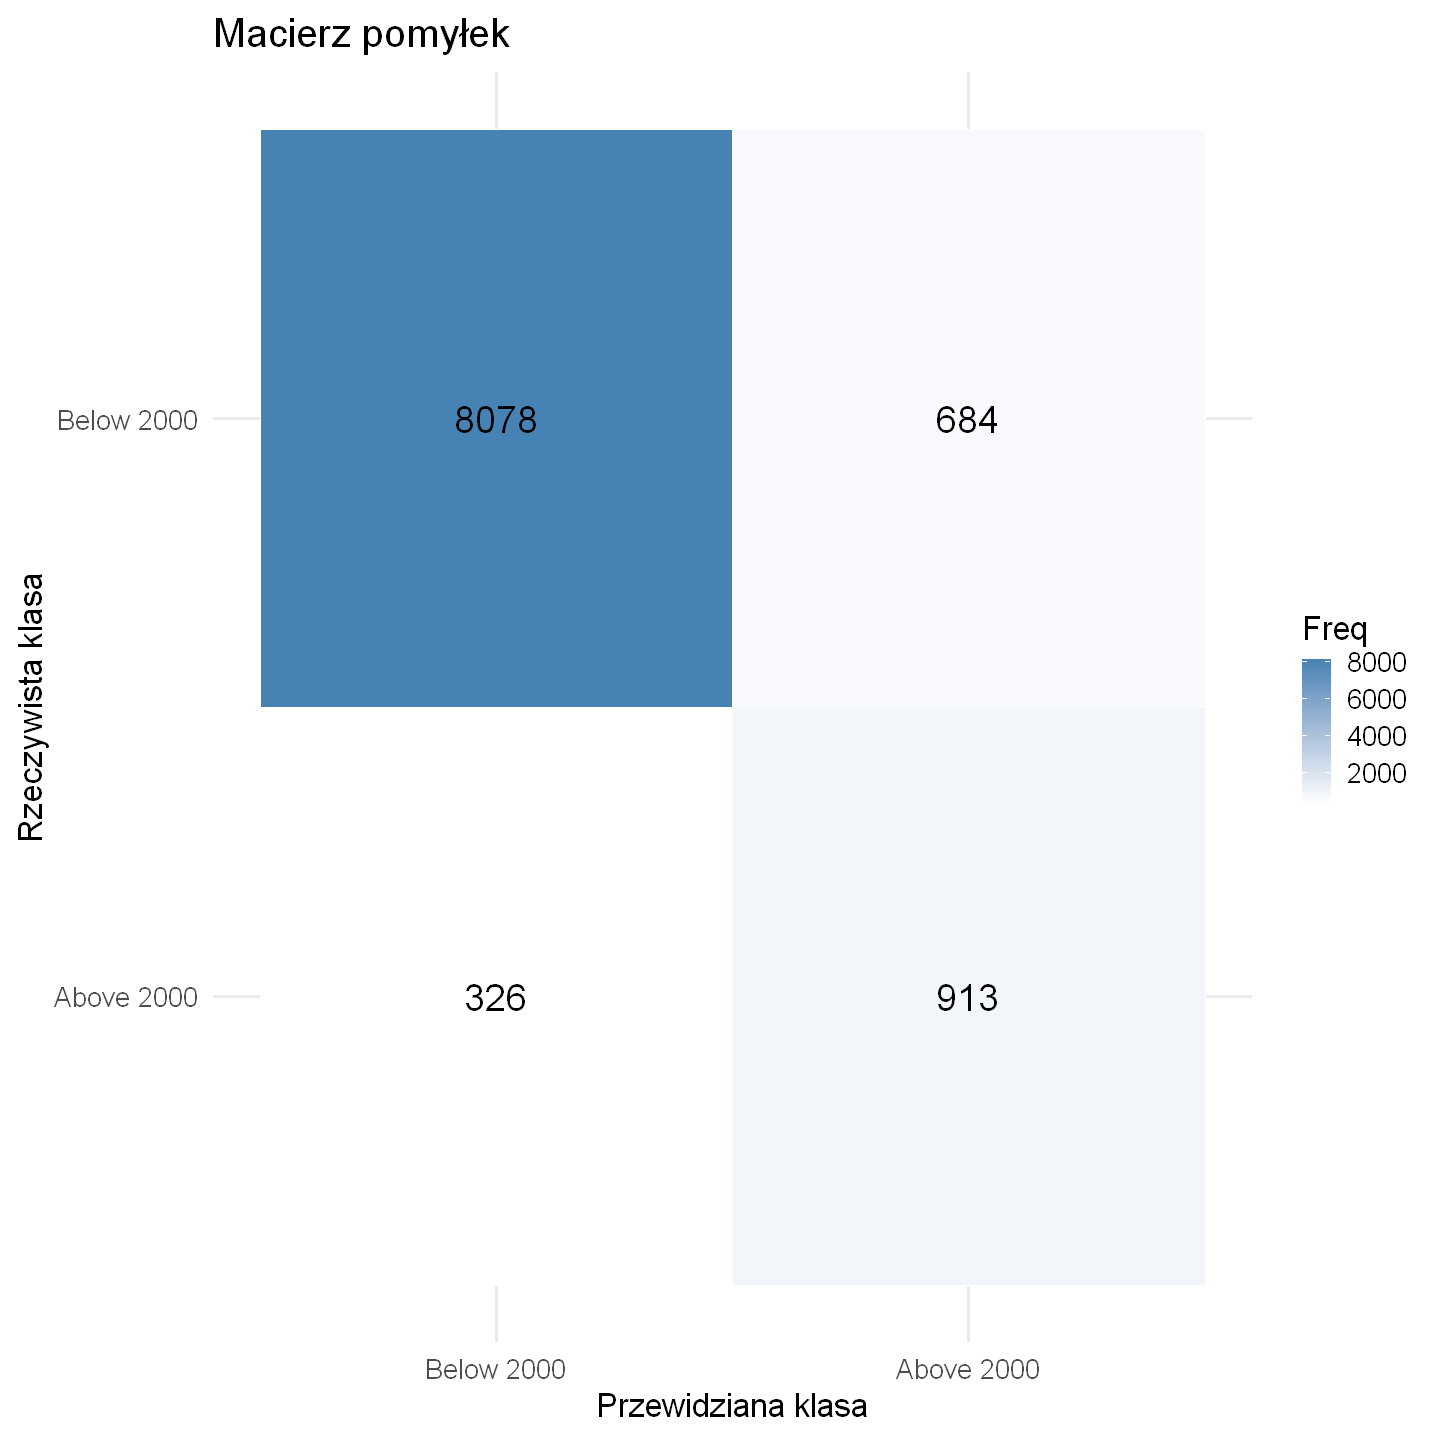

In [17]:
plot_confusion_heatmap(dir_logistic$cm)

Model dosyć dobrze radzi sobie z predykcją właściwej klasy. Jeśli jednak już się myli, to częściej klasyfikuje graczy w rzeczywistości poniżej 2000 jako graczy powyżej 2000 rankingu.

In [18]:
# A helper function for calculating and printing basic evaluation metrics
evaluate_confusion_matrix <- function(cm) {
  TP <- cm["Above 2000", "Above 2000"]
  FN <- cm["Above 2000", "Below 2000"]
  FP <- cm["Below 2000", "Above 2000"]
  TN <- cm["Below 2000", "Below 2000"]
  
  accuracy <- (TP + TN) / (TP + TN + FP + FN)
  precision <- TP / (TP + FP)
  recall <- TP / (TP + FN)
  f1 <- 2 * (precision * recall) / (precision + recall)
  
  cat("Accuracy:", round(accuracy, 4), "\n")
  cat("Precision:", round(precision, 4), "\n")
  cat("Recall:", round(recall, 4), "\n")
  cat("F1-score:", round(f1, 4), "\n")
}

In [19]:
evaluate_confusion_matrix(dir_logistic$cm)

Accuracy: 0.899 
Precision: 0.5717 
Recall: 0.7369 
F1-score: 0.6439 


Model klasyfikacyjny osiągnął wysoką trafność (accuracy) na poziomie 89,9%, co oznacza, że poprawnie sklasyfikował większość przypadków. Precyzja wynosząca 57,2% wskazuje, że spośród graczy zaklasyfikowanych jako posiadających ponad 2000 elo, tylko nieco ponad połowa rzeczywiście spełnia ten warunek. Z kolei recall na poziomie 73,7% oznacza, że model dobrze wychwytuje graczy z wyższym poziomem, poprawnie identyfikując większość z nich. F1-score, będący średnią harmoniczną precyzji i recallu, wynosi 64,4% i pokazuje zrównoważoną skuteczność modelu w rozpoznawaniu klasy "Above 2000", choć jest jeszcze miejsce na poprawę, szczególnie w zakresie ograniczania liczby fałszywych trafień.

Dla celów porównawczych, przeprowadzamy teraz predykcję na zbiorze testowym, który nie był wykorzystywany podczas uczenia modelu:

In [ ]:
dir_logistic_t <- list()
dir_logistic_t$fit <- dir_logistic$fit      # No need to repeat training process

dir_logistic_t$probs <- predict(dir_logistic_t$fit, data_test, type = "response")
dir_logistic_t$predicted <- ifelse(dir_logistic_t$probs > 0.5, "Above 2000", "Below 2000")

# Create confusion matrix
dir_logistic_t$cm <- table(dir_logistic_t$predicted, data_test$elo_category)

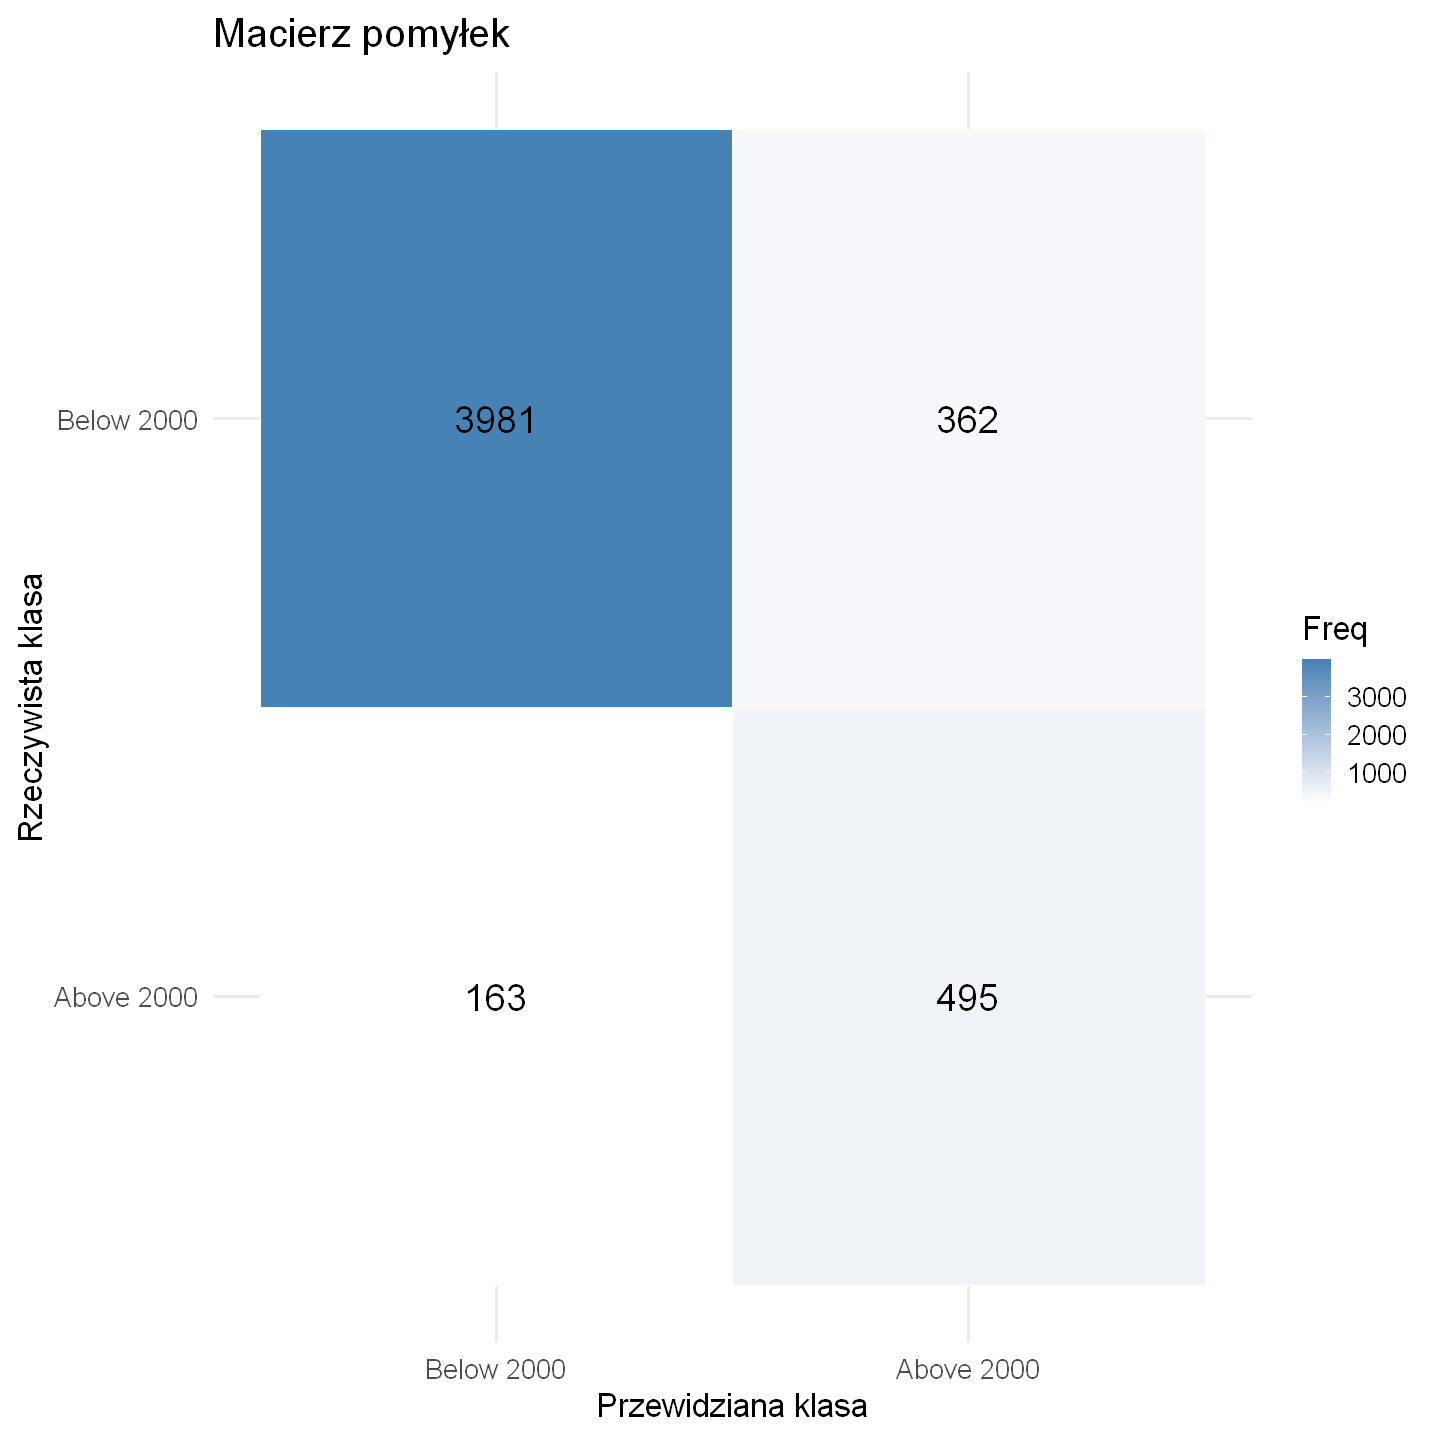

In [26]:
plot_confusion_heatmap(dir_logistic_t$cm)

In [27]:
evaluate_confusion_matrix(dir_logistic_t$cm)

Accuracy: 0.895 
Precision: 0.5776 
Recall: 0.7523 
F1-score: 0.6535 


Otrzymane wyniki dla zbioru testowego są zbliżone do tych dla zbioru treningowego. Oznacza to dobrą generalizację modelu.

Na koniec testujemy model regresji logistycznej wytrenowany z użyciem tylko dwóch najbardziej istotnych cech: ```avg_cp_loss``` i ```avg_blund```:

In [29]:
dir_logistic_best2 <- list()
dir_logistic_best2$fit <- glm(elo_category ~ avg_cp_loss + avg_blund, 
                              family = binomial, data = data_train)

# Calculate probabilities and make predictions
dir_logistic_best2$probs <- predict(dir_logistic_best2$fit, data_test, type = "response")
dir_logistic_best2$predicted <- ifelse(dir_logistic_best2$probs > 0.5, "Above 2000", "Below 2000")

# Create confusion matrix
dir_logistic_best2$cm <- table(dir_logistic_best2$predicted, data_test$elo_category)

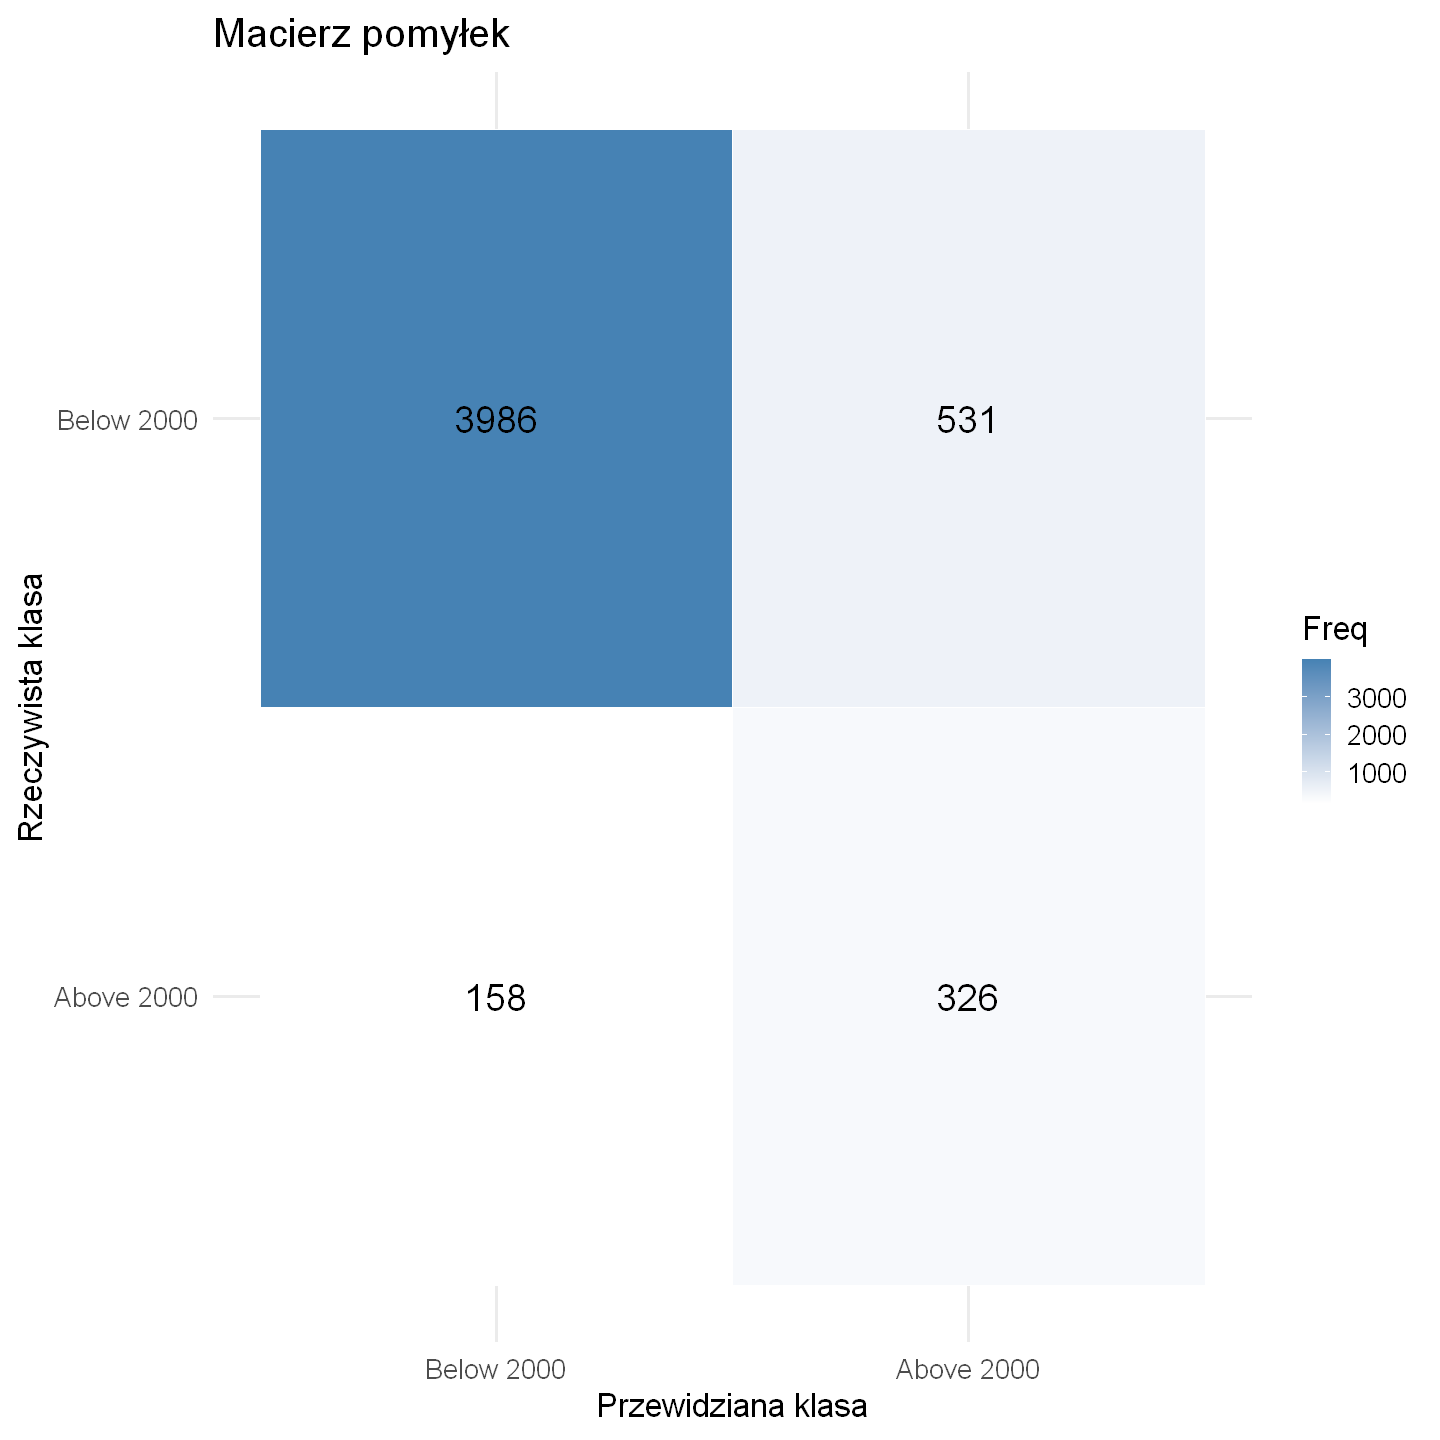

In [30]:
plot_confusion_heatmap(dir_logistic_best2$cm)

In [32]:
evaluate_confusion_matrix(dir_logistic_best2$cm)

Accuracy: 0.8622 
Precision: 0.3804 
Recall: 0.6736 
F1-score: 0.4862 


Widzimy wyraźny spadek wartości metryk, zwłaszcza precyzji. Oznacza to pojawienie się znacznie większej liczby przypadków fałszywie pozytywnych (wzrost o ponad $46\%$, z $362$ na $531$). Ponieważ zbiór jest niezbalansowany i większość graczy posiada mniej niż 2000 punktów rankingowych, świadczy to o poważnym spadku skuteczności klasyfikatora i potwierdza zasadność użycia większej liczby cech w klasyfikacji.

### 3.5 LDA

In [43]:
dir_lda <- list()
dir_lda$fit <- lda(elo_category ~ avg_cp_loss + avg_blund, data = data_train)

dir_lda$predicted <- predict(dir_lda$fit, data_test)

dir_lda$cm <- table(
  Predicted = dir_lda$predicted$class,
  Actual    = data_test$elo_category
)

In [44]:
evaluate_confusion_matrix(dir_lda$cm)

Accuracy: 0.8516 
Precision: 0.2007 
Recall: 0.7511 
F1-score: 0.3168 


Wartość czułości (recall) wzrosła, jednak precyzja zanotowała znaczny spadek względem wyniku dla regresji logistycznej, co oznacza jeszcze więcej wyników fałszywie pozytywnych (tudzież graczy fałszywie sklasyfikowanych jako powyżej 2000 elo).

### 3.6 QDA

In [49]:
dir_qda <- list()
dir_qda$fit <- qda(elo_category ~ avg_cp_loss + avg_blund, data = data_train)

dir_qda$predicted <- predict(dir_qda$fit, data_test)

dir_qda$cm <- table(
  Predicted = dir_qda$predicted$class,
  Actual    = data_test$elo_category
)

In [50]:
evaluate_confusion_matrix(dir_qda$cm)

Accuracy: 0.8494 
Precision: 0.4131 
Recall: 0.5861 
F1-score: 0.4846 


Tym razem precyzja wzrosła, choć spadła czułość. Wynik wciąż jest jednak gorszy od regresji logistycznej dla dwóch zmiennych.

### 3.7 kNN

In [56]:
data_train_selected <- data_train[, c("avg_cp_loss", "avg_blund")]
data_test_selected <- data_test[, c("avg_cp_loss", "avg_blund")]

In [62]:
set.seed(410375)

ks <- c(1, 3, 5, 10)

for (k in ks) {
  preds <- knn(
    train = data_train_selected,
    test  = data_test_selected,
    cl    = data_train$elo_category,
    k     = k
  )
  
  cm <- table(
    Predicted = preds,
    Actual    = data_test$elo_category
  )
  
  cat(sprintf("kNN with k = %d:\n", k))
  cat("--------------------\n")
  evaluate_confusion_matrix(cm)
  cat("\n\n")
}

kNN with k = 1:
--------------------
Accuracy: 0.812 
Precision: 0.4282 
Recall: 0.4492 
F1-score: 0.4385 


kNN with k = 3:
--------------------
Accuracy: 0.8396 
Precision: 0.4166 
Recall: 0.5417 
F1-score: 0.471 


kNN with k = 5:
--------------------
Accuracy: 0.8454 
Precision: 0.4154 
Recall: 0.5669 
F1-score: 0.4795 


kNN with k = 10:
--------------------
Accuracy: 0.855 
Precision: 0.4306 
Recall: 0.6089 
F1-score: 0.5044 




Wyniki pokazują, jak zmieniają się podstawowe metryki klasyfikacji kNN w zależności od liczby sąsiadów $k$. Wraz ze wzrostem $k$ dokładność (accuracy) modelu rośnie – od około 81,2% przy $k=1$ do 85,5% przy $k=10$, co sugeruje, że większa liczba sąsiadów pozwala na bardziej stabilne i trafne klasyfikacje. Jednak precyzja (precision) nie rośnie równomiernie i utrzymuje się na podobnym poziomie około 41–43%, co oznacza, że odsetek poprawnych pozytywnych klasyfikacji względem wszystkich przewidzianych pozytywnych jest umiarkowany. Z kolei recall (czułość) systematycznie wzrasta z 44,9% do 60,9%, co wskazuje, że model coraz lepiej wykrywa faktyczne przypadki pozytywne wraz ze wzrostem $k$. Podsumowując, najlepszy kompromis między precyzją a czułością osiągnięto dla $k=10$, co potwierdza również najwyższy wynik F1-score (około 0,50). Oznacza to, że model przy $k=10$ jest najbardziej efektywny w zrównoważonym wykrywaniu pozytywnych klas.
Osiąga on zarazem porównywalną skuteczność co regresja logistyczna w wariancie z dwoma zmiennymi.